In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from skimage import transform
import os
from tqdm import tqdm
import math

CC = False

In [19]:
# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

random.seed(3)
rgb_dict_with_function = {i: (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for i in range(10)}

In [18]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
X = np.concatenate([x_train, x_test], axis=0)
Y = np.concatenate([y_train, y_test], axis=0)
Y = np.expand_dims(Y, -1)

(70000, 1)

In [4]:
def to_center_coordinates(x_min, y_min, x_max, y_max):
    """
    Converts top-left and bottom-right coordinates of a bounding box to
    center coordinates with width and height.

    Parameters:
    x_min (float) : X coordinate of top-left corner
    y_min (float) : Y coordinate of top-left corner
    x_max (float) : X coordinate of bottom-right corner
    y_max (float) : X coordinate of bottom-right corner

    Returns:
    list: [center_x, center_y, width, height]
    """
    width = x_max - x_min
    height = y_max - y_min
    center_x = x_min + width / 2
    center_y = y_min + height / 2
    
    return [center_x, center_y, width, height]


def to_corner_coordinates(center_x, center_y, width, height):
    """
    Converts center coordinates with width and height to
    top-left and bottom-right coordinates of a bounding box.

    Parameters:
    center_x (float): X coordinates of the center 
    center_y (float): Y coordinates of the center 
    width (float): Width of the bounding box
    height (float): Height of the bounding box

    Returns:
    list: [x_min, y_min, x_max, y_max]
    """
    x_min = center_x - width / 2
    y_min = center_y - height / 2
    x_max = center_x + width / 2
    y_max = center_y + height / 2
    
    return [x_min, y_min, x_max, y_max]
    

In [5]:
def find_bbox(object, 
              corner_coordinates=True):
    """
    Definition:
    Locates the bounding box pixel coordinates of the non-zero pixels
    in the image. Can return in corner coordinates or center, width, height.

    Parameters:
    object (np.array)         : 2D image array
    corner_coordinates (bool) : Specifies output format
    
    Returns:
    np.array : [x_min, y_min, x_max, y_max]
    or
    np.array : [center_x, center_y, width, height]
    """
    # Find the non-zero pixels
    coords = np.column_stack(np.where(object > 0)).astype(float)
    coords[:, 0] = coords[:, 0] / object.shape[0]
    coords[:, 1] = coords[:, 1] / object.shape[1]
    # Find the top_left bottom_right bounding box coordinates
    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)

    # return specified label-type (corner coordinates) 
    if corner_coordinates:
        return np.array([x_min, y_min, x_max, y_max])
    # (center-coordinate, width, height)
    else:
        return np.array(to_center_coordinates(x_min, y_min, x_max, y_max))


def add_bbox_to_object(object, 
                       label, 
                       label_color_map, 
                       corner_coordinates=True):
    """
    Definition

    Parameters:
    
    Returns:

    """
    # retrieve rectangle coordinates
    if corner_coordinates:
        x_min, y_min, x_max, y_max = label[1:]
    else:
        center_x, center_y, width, height = label[1:]
        x_min, y_min, x_max, y_max = to_corner_coordinates(center_x, center_y, width, height)
    # Upscale from normalized coordinates
    x_min = int(np.floor(x_min * object.shape[0]))
    y_min = int(np.floor(y_min * object.shape[1]))
    x_max = int(np.ceil(x_max * object.shape[0]))
    y_max = int(np.ceil(y_max * object.shape[1]))

    object = np.stack([object, object, object], axis=-1)  # Convert to RGB
    object_with_bbox = cv2.rectangle(object, 
                                     (y_min, x_min), 
                                     (y_max, x_max),
                                     color=label_color_map[label[0]], 
                                     thickness=1)
    # Calculate normalized coordinates
    return object_with_bbox


def plot_mnist_objects_with_bbox(objects, 
                                 labels, 
                                 label_color_map,
                                 classes = 10,
                                 repeats = 5,
                                 corner_coordinates=True):
    """
    Definition

    Parameters:
    
    Returns:

    """
    plt.figure(figsize=(2 * classes, 2 * repeats))
    for i in range(repeats):
        for j in range(classes):
            plt.subplot(repeats, classes, i * classes + j + 1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            # find the index of the first example of current i in data 
            index = np.where(labels[:, 0] == j)[0][i]

            object_with_bbox = add_bbox_to_object(objects[index],
                                                  labels[index],
                                                  label_color_map,
                                                  corner_coordinates=corner_coordinates)
            plt.imshow(object_with_bbox)
            plt.xlabel(j)
    plt.show()


def plot_image_from_grayscale(object):
    """
    Definition

    Parameters:
    
    Returns:

    """
    object = np.stack([object, object, object], axis=-1)
    plt.figure(figsize=(6, 6))
    plt.imshow(object, vmin=0, vmax=255)
    plt.axis('off')
    plt.show()

def draw_grid_on_image(image, grid_height, grid_width):
    """
    Definition

    Parameters:
    
    Returns:

    """
    # Get the shape of the image
    height, width = image.shape
    
    # Calculate the step size for rows and columns
    row_step = height // grid_height
    col_step = width // grid_width

    # Set grid lines to zero (black)
    for i in range(1, grid_height):
        image[i * row_step, :] = 0  # Horizontal lines
    for j in range(1, grid_width):
        image[:, j * col_step] = 0  # Vertical lines

    return image


In [6]:
x_train_bboxes = []
for object in x_train:
    x_train_bboxes.append(find_bbox(object, corner_coordinates=CC))
x_train_bboxes = np.array(x_train_bboxes)

y_train_bboxes = np.hstack([y_train, x_train_bboxes])

x_test_bboxes = []
for object in x_test:
    x_test_bboxes.append(find_bbox(object, corner_coordinates=CC))
x_test_bboxes = np.array(x_test_bboxes)

y_test_bboxes = np.hstack([y_test, x_test_bboxes])

In [7]:
y_train_bboxes[10]

array([3.        , 0.48214286, 0.44642857, 0.67857143, 0.46428571])

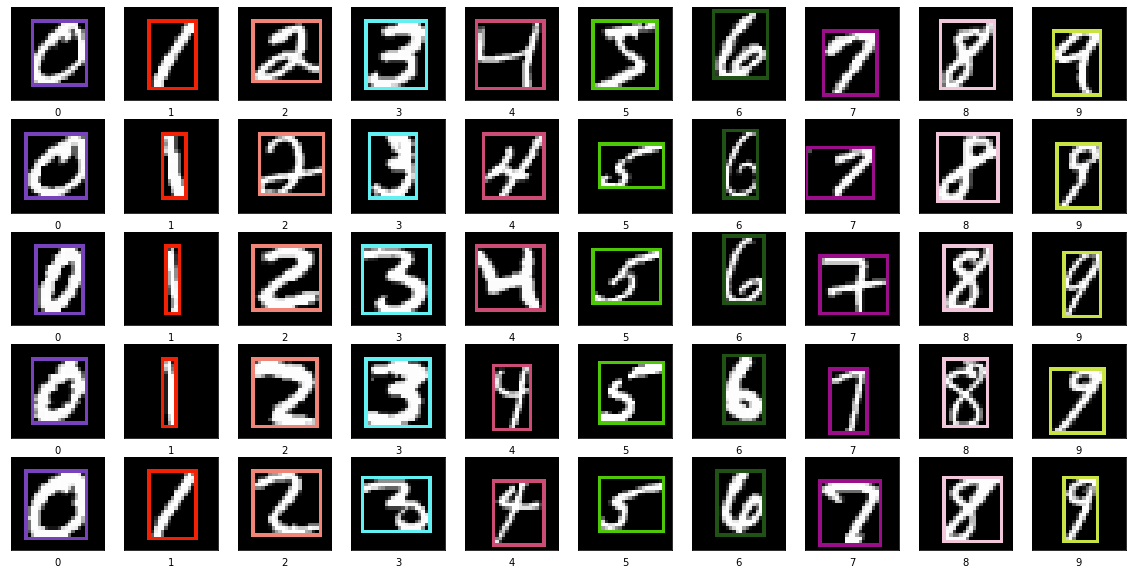

In [8]:
plot_mnist_objects_with_bbox(x_train,
                            y_train_bboxes,
                            label_color_map=rgb_dict_with_function,
                            corner_coordinates=CC)

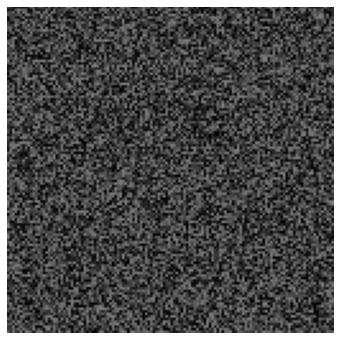

In [9]:
def generate_noisy_image(size=(128, 128),
                         intensity = 128):
    """
    Definition

    Parameters:
    
    Returns:

    """
    # Generate a random array of shape size with values between 0 and 255
    random_image = np.random.randint(0, intensity, size, dtype=np.uint8)
    return random_image

# Generate a random 64x64 grayscale object
image = generate_noisy_image()

# Display the object
plot_image_from_grayscale(image)

In [10]:
def choose_regions_to_populate(max_objects = 8,
                               grid_height = 4,
                               grid_width = 4):
    """
    Definition

    Parameters:
    
    Returns:

    """
    
    num_objects = np.random.choice(range(max_objects), 1)
    regions = np.random.choice(range(1, grid_width * grid_height + 1), 
                               num_objects, 
                               replace=False)
    return regions

In [11]:
def grab_x_bbox_region(object, 
                       label,
                       corner_coordinates=True):
    """
    Definition

    Parameters:
    
    Returns:

    """
        
    if corner_coordinates:
        x_min, y_min, x_max, y_max = label[1:]
    else:
        center_x, center_y, width, height = label[1:]
        x_min, y_min, x_max, y_max = to_corner_coordinates(center_x, center_y, width, height)

    # Upscale from normalized coordinates
    x_min = int(np.floor(x_min * object.shape[0]))
    y_min = int(np.floor(y_min * object.shape[1]))
    x_max = int(np.ceil(x_max * object.shape[0]))
    y_max = int(np.ceil(y_max * object.shape[1]))

    return object[x_min:x_max, y_min:y_max]

In [79]:
def add_object_to_image(image,
                        region_of_interest,
                        object,
                        label,
                        object_num,
                        grid_height = 4,
                        grid_width = 4,
                        scale_value = 1,
                        corner_coordinates=True):
    """
    Definition

    Parameters:
    
    Returns:

    """

    # Determine the size of a region based on chosen image grid
    region_y = int(image.shape[0] / grid_height)
    region_x = int(image.shape[1] / grid_width)
    # Randomly choose a center point within the size of one grid region
    x_center = np.random.randint(0, region_x + 1, 1)
    y_center = np.random.randint(0, region_y + 1, 1)
    # Offset center to the chosen region of interest 

    x_center += ((region_of_interest - 1)// grid_width) * region_x
    y_center += ((region_of_interest - 1) % grid_width) * region_y
    
    # Grab the bbox area of the input object for overlaying onto the image
    bbox_object = grab_x_bbox_region(object,
                                     label,
                                     corner_coordinates=corner_coordinates)
   
    m, n = bbox_object.shape
    # Find all edge regions on graph such that no scaling will happen in these regions due to potential to be placed outside image
    edge_regions = list(range(1, grid_width + 1))
    edge_regions += list(range(grid_width + 1, (grid_height - 1) * grid_width , grid_width))
    edge_regions += list(range(grid_width * 2, ((grid_height - 1) * grid_width  + 1), grid_width))
    edge_regions += list(range((grid_height - 1) * grid_width + 1, grid_height * grid_width + 1))

    if scale_value > min(region_y / n, region_x / m) * 2 :
        scale_value = (math.floor(min(region_y / n, region_x / m) * 20) / 10) - 0.5
    
    if scale_value != 1: # and region_of_interest not in edge_regions:
        bbox_object = transform.rescale(bbox_object, 
                                        scale_value,
                                        mode = 'constant',
                                        cval = 0,
                                        anti_aliasing=False,
                                        preserve_range=True)
    # Find new size of bbox object
    m, n = bbox_object.shape
    
    # Calculate image location for bbox object
    y_min = int((y_center[0] - n // 2))
    x_min = int((x_center[0] - m // 2))
    y_max = int(y_min + n)
    x_max = int(x_min + m)

    if y_min < 0:
        up_shift = 0 - y_min
        y_min, y_max = y_min + up_shift, y_max + up_shift
    elif y_max >= image.shape[1]:
        down_shift = (y_max - image.shape[1]) + 1
        y_min, y_max = y_min - down_shift, y_max - down_shift  

    if x_min < 0:
        r_shift = 0 - x_min
        x_min, x_max = x_min + r_shift, x_max + r_shift
    elif x_max >= image.shape[0]:
        l_shift = (x_max - image.shape[0]) + 1
        x_min, x_max = x_min - l_shift, x_max - l_shift

    image[x_min:x_max, y_min:y_max] = np.maximum(image[x_min:x_max, y_min:y_max], bbox_object)

    M, N = image.shape

    if corner_coordinates:
        added_object = {object_num : {'class' : int(label[0]),
                                      'bbox_true' : [x_min,     y_min,     x_max,     y_max    ],
                                      'bbox_norm' : [x_min / M, y_min / N, x_max / M, y_max / N]}
                        }
    else:
        center_x, center_y, width, height = to_center_coordinates(x_min, y_min, x_max, y_max)
        added_object = {object_num : {'class' : int(label[0]),
                                      'bbox_true' : [center_x,     center_y,     width,     height     ],
                                      'bbox_norm' : [center_x / M, center_y / N, width / M, height / N]}}

    #print('x: ', center_x, ' y: ', center_y)   
    #print('x_reg: ', center_x // region_x, ' y reg: ', center_y // region_y)

    return image, added_object


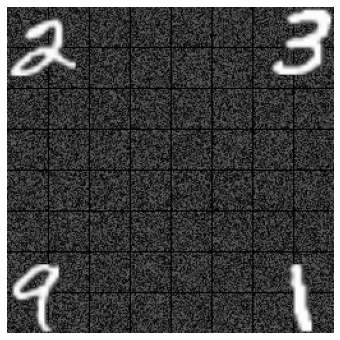

In [80]:
image = generate_noisy_image(size = (256, 256), intensity = 100)
draw_grid_on_image(image, grid_height = 8, grid_width = 8)

image, _ = add_object_to_image(image = image,
                            region_of_interest = 1,
                            object = x_train[5],
                            label = y_train_bboxes[5],
                            object_num = 1,
                            grid_height = 8,
                            grid_width = 8,
                            scale_value = 5,
                            corner_coordinates=CC)

image, _ = add_object_to_image(image = image,
                            region_of_interest = 8,
                            object = x_train[7],
                            label = y_train_bboxes[7],
                            object_num = 2,
                            grid_height = 8,
                            grid_width = 8,
                            scale_value = 5,
                            corner_coordinates=CC)

image, _ = add_object_to_image(image = image,
                            region_of_interest = 64,
                            object = x_train[6],
                            label = y_train_bboxes[6],
                            object_num = 3,
                            grid_height = 8,
                            grid_width = 8,
                            scale_value = 5,
                            corner_coordinates=CC)

image, _ = add_object_to_image(image = image,
                            region_of_interest = 57,
                            object = x_train[4],
                            object_num = 4,
                            label = y_train_bboxes[4],
                            grid_height = 8,
                            grid_width = 8,
                            scale_value = 5,
                            corner_coordinates=CC)

plot_image_from_grayscale(image)

In [64]:
import copy

def create_image(objects,
                 labels,
                 image_size = (128, 128),
                 noise_intensity = 180,
                 grid_height = 4,
                 grid_width = 4,
                 max_objects = 8,
                 max_scaling = 2.5,
                 add_gridlines = False,
                 allow_overlap = False,
                 corner_coordinates=True):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters:
    
    Returns:

    """
    
    image = generate_noisy_image(size = image_size,
                                 intensity = noise_intensity)

    
    data_size = len(objects)
    scaling_options = np.arange(1, max_scaling + 0.125, 0.125)

    regions_to_populate = choose_regions_to_populate(max_objects=max_objects,
                                                     grid_height = grid_width,
                                                     grid_width = grid_width)
    
    if add_gridlines:
        image = draw_grid_on_image(image, 
                                   grid_height = grid_height, 
                                   grid_width = grid_width)
        
    added_objects = {}

    #print('regions to populate: {}'.format(regions_to_populate))

    
    for object_num, region in enumerate(regions_to_populate):
       
        index = np.random.randint(0, data_size)
        scaler = np.random.choice(scaling_options)
        
        temp_image, object_to_add = add_object_to_image(image = copy.deepcopy(image),
                                                        region_of_interest = region,
                                                        object = objects[index],
                                                        label = labels[index],
                                                        object_num = object_num,
                                                        grid_height = grid_height,
                                                        grid_width = grid_width,
                                                        scale_value = scaler,
                                                        corner_coordinates=corner_coordinates)
        

        overlap = False

        if object_num > 0 and not allow_overlap:
            added_objects_list = list(added_objects.values())
            for added_object in added_objects_list:
                overlap = check_overlap(object_to_add[object_num]['bbox_true'],
                                        added_object['bbox_true'],
                                        corner_coordinates=corner_coordinates)
                if overlap:
                    #print('deleted item in region {}'.format(region))
                    break
        
        if not overlap:
            added_objects.update(object_to_add)
            image = temp_image
            #print("object_num: {}, region: {} , number: {}".format(object_num, region, int(labels[index, 0])))
        
        del temp_image

            
    
    return image, added_objects

In [65]:
def calculate_iou(bbox1, 
                  bbox2,
                  corner_coordinates=True):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters:
    box1: tuple or list of (x1, y1, x2, y2) representing the coordinates of the first box
    box2: tuple or list of (x1, y1, x2, y2) representing the coordinates of the second box
    
    Returns:
    IoU: float, intersection over union value
    """
    # Unpack the coordinates
    if corner_coordinates:
        x1_min, y1_min, x1_max, y1_max = bbox1
        x2_min, y2_min, x2_max, y2_max = bbox2
    else:
        center1_x, center1_y, width1, height1 = bbox1
        x1_min, y1_min, x1_max, y1_max = to_corner_coordinates(center1_x, center1_y, width1, height1)
        center2_x, center2_y, width2, height2 = bbox2
        x2_min, y2_min, x2_max, y2_max = to_corner_coordinates(center2_x, center2_y, width2, height2)
    

    # Calculate the coordinates of the intersection rectangle
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    # Compute the area of the intersection rectangle
    inter_width = max(0, inter_x_max - inter_x_min)
    inter_height = max(0, inter_y_max - inter_y_min)
    inter_area = inter_width * inter_height

    # Compute the area of both bounding boxes
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    # Compute the union area
    union_area = box1_area + box2_area - inter_area

    # Compute IoU
    iou = inter_area / union_area if union_area != 0 else 0

    return iou

def check_overlap(bbox1, 
                  bbox2,
                  corner_coordinates=True):
    """
    Check if two bounding boxes in center-width-height format overlap.

    Parameters:
    box1: tuple or list of (cx1, cy1, w1, h1) representing the center coordinates, width, and height of the first box
    box2: tuple or list of (cx2, cy2, w2, h2) representing the center coordinates, width, and height of the second box
    
    Returns:
    overlap: bool, True if the boxes overlap, False otherwise
    """
    # Unpack the coordinates
    if corner_coordinates:
        x1_min, y1_min, x1_max, y1_max = bbox1
        x2_min, y2_min, x2_max, y2_max = bbox2
    else:
        center1_x, center1_y, width1, height1 = bbox1
        x1_min, y1_min, x1_max, y1_max = to_corner_coordinates(center1_x, center1_y, width1, height1)
        center2_x, center2_y, width2, height2 = bbox2
        x2_min, y2_min, x2_max, y2_max = to_corner_coordinates(center2_x, center2_y, width2, height2)

    # Check if the boxes do not overlap
    if x1_max < x2_min or x2_max < x1_min:  # One box is to the left of the other
        return False
    if y1_max < y2_min or y2_max < y1_min:  # One box is above the other
        return False

    # If none of the above conditions are true, the boxes overlap
    return True


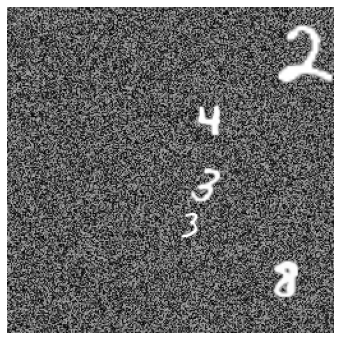

[{'class': 3,
  'bbox_true': [171.0, 142.0, 20, 14],
  'bbox_norm': [0.66796875, 0.5546875, 0.078125, 0.0546875]},
 {'class': 8,
  'bbox_true': [213.0, 217.5, 30, 21],
  'bbox_norm': [0.83203125, 0.849609375, 0.1171875, 0.08203125]},
 {'class': 3,
  'bbox_true': [140.0, 154.5, 26, 25],
  'bbox_norm': [0.546875, 0.603515625, 0.1015625, 0.09765625]},
 {'class': 2,
  'bbox_true': [37.5, 232.5, 45, 45],
  'bbox_norm': [0.146484375, 0.908203125, 0.17578125, 0.17578125]},
 {'class': 4,
  'bbox_true': [88.5, 157.0, 25, 20],
  'bbox_norm': [0.345703125, 0.61328125, 0.09765625, 0.078125]}]

In [84]:
image, added_objects = create_image(x_train,
                                    y_train_bboxes,
                                    image_size         = (256, 256),
                                    noise_intensity    = 180,
                                    grid_height        = 8,
                                    grid_width         = 8,
                                    max_objects        = 12,
                                    max_scaling        = 3.5,
                                    add_gridlines      = False,
                                    allow_overlap      = False,
                                    corner_coordinates = CC)

plot_image_from_grayscale(image)
list(added_objects.values())

In [85]:
def plot_mnist_image_with_bboxes(image, 
                                 added_objects, 
                                 label_color_map,
                                 corner_coordinates=True):

    plt.figure(figsize=(6,6))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image = np.stack([image, image, image], axis=-1)

    for _ , value in added_objects.items():
        
        if corner_coordinates:
            x_min, y_min, x_max, y_max = value['bbox_true']
        else:
            center_x, center_y, width, height = value['bbox_true']
            x_min, y_min, x_max, y_max = to_corner_coordinates(center_x, center_y, width, height)

        image = cv2.rectangle(image, 
                              (int(y_min), int(x_min)),
                              (int(y_max), int(x_max)),  
                              color=label_color_map[value['class']], 
                              thickness=1)
    
    plt.imshow(image)
    plt.show()

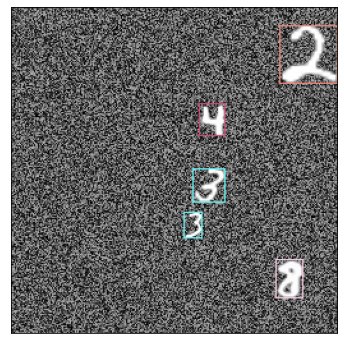

{0: {'class': 3,
  'bbox_true': [171.0, 142.0, 20, 14],
  'bbox_norm': [0.66796875, 0.5546875, 0.078125, 0.0546875]},
 1: {'class': 8,
  'bbox_true': [213.0, 217.5, 30, 21],
  'bbox_norm': [0.83203125, 0.849609375, 0.1171875, 0.08203125]},
 2: {'class': 3,
  'bbox_true': [140.0, 154.5, 26, 25],
  'bbox_norm': [0.546875, 0.603515625, 0.1015625, 0.09765625]},
 4: {'class': 2,
  'bbox_true': [37.5, 232.5, 45, 45],
  'bbox_norm': [0.146484375, 0.908203125, 0.17578125, 0.17578125]},
 7: {'class': 4,
  'bbox_true': [88.5, 157.0, 25, 20],
  'bbox_norm': [0.345703125, 0.61328125, 0.09765625, 0.078125]}}

In [86]:
plot_mnist_image_with_bboxes(image, 
                             added_objects, 
                             rgb_dict_with_function,
                             corner_coordinates=CC)

added_objects

In [77]:
def create_dataset(dataset_output_dir,
                   num_images,
                   objects,
                   labels,
                   image_size = (128, 128),
                   noise_intensity = 180,
                   grid_height = 4,
                   grid_width = 4,
                   max_objects = 8,
                   max_scaling = 2.5,
                   add_gridlines = False,
                   allow_overlap = False,
                   corner_coordinates=True):
    
    """


    Parameters:

    
    Returns:

    """

    if not os.path.exists(dataset_output_dir):
        os.makedirs(dataset_output_dir)

    image_output_dir = os.path.join(dataset_output_dir, r"images")
    label_output_dir = os.path.join(dataset_output_dir, r"labels")
    dirs = [image_output_dir, label_output_dir]

    for dir in dirs:
        if not os.path.exists(dir):
            os.makedirs(dir)
    
    for i in tqdm(range(num_images), desc="Processing"):
        image_id = f"{i:08d}"
        
        image, added_objects = create_image(objects            = objects,
                                            labels             = labels,
                                            image_size         = image_size,
                                            noise_intensity    = noise_intensity,
                                            grid_height        = grid_height,
                                            grid_width         = grid_width,
                                            max_objects        = max_objects,
                                            max_scaling        = max_scaling,
                                            add_gridlines      = add_gridlines,
                                            allow_overlap      = allow_overlap,
                                            corner_coordinates = corner_coordinates)
        
        image_filename = f"{image_id}.jpg"
        image_path = os.path.join(image_output_dir, image_filename)
        cv2.imwrite(image_path, image)

        labels_list = []
        for added_object in added_objects.values():
            class_id = added_object['class']
            center_x, center_y, width, height = added_object['bbox_norm']
            labels_list.append(f"{class_id} {center_x:.6f} {center_y:.6f} {width:.6f} {height:.6f}")

        # Write the YOLO annotation text file
        label_filename = f"{image_id}.txt"
        label_path = os.path.join(label_output_dir, label_filename)
        with open(label_path, 'w') as f:
            f.write("\n".join(labels_list))    
    

In [87]:
create_dataset(r"C:\Users\matth\Documents\Code\Python\MNIST_ObjectDetection_Dataset\Test",
               1000,
               x_train,
               y_train_bboxes,
               image_size = (256, 256),
               noise_intensity = 180,
               grid_height = 8,
               grid_width = 8,
               max_objects = 10,
               max_scaling = 5,
               add_gridlines = False,
               allow_overlap = False,
               corner_coordinates=False)

Processing: 100%|██████████| 1000/1000 [00:04<00:00, 214.99it/s]
